In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import ttest_ind
import json
import lib.galaxy_utilities as gu
from astropy.io import fits
import requests

In [3]:
# %run make_bulge_bar_dataframes.py

In [4]:
bulge_df = pd.read_pickle('bulge_fractions.pkl').dropna()
bar_df = pd.read_pickle('bar_fractions.pkl').dropna()
bar_length_df = pd.read_pickle('bar_lengths.pkl')
display(bulge_df.head(3))
display(bar_df.head(3))
display(bar_length_df.head(3))

,GZB fraction,GZ2 bulge dominated
subject_id,,
20902000,0.571429,True
20902007,0.937500,True
20902059,0.705882,False


,GZB fraction,GZ2 bar fraction,Strongly barred,No bar
subject_id,,,,
20902000,0.428571,0.736751,True,False
20902007,0.312500,0.072191,False,True
20902059,0.235294,0.212000,False,False


,GZB bar length,GZ2 bar fraction,GZB fraction
subject_id,,,
20902000,NaN,0.736751,0.428571
20902007,NaN,0.072191,0.312500
20902059,75.75,0.212000,0.235294


In [5]:
len(bulge_df), len(bar_df), len(bar_length_df)

(170, 170, 171)

## How frequently do people draw bulges relative to GZ2 pBulge?

In [6]:
gzb_bulge_mean = bulge_df['GZB fraction'].mean()
gzb_bulge_std = bulge_df['GZB fraction'].std()
print('\nGZB bulge fraction = {:.4f} ± {:.5f}\n'.format(
    gzb_bulge_mean, gzb_bulge_std
))
bulge_groups = bulge_df.groupby('GZ2 bulge dominated')
display(pd.DataFrame(
    np.hstack((bulge_groups.mean(), bulge_groups.std())),
    columns=('mean', 'std'),
    index=bulge_groups.mean().index
))

ttest_result = ttest_ind(
    bulge_df[bulge_df['GZ2 bulge dominated']]['GZB fraction'].values,
    bulge_df[~bulge_df['GZ2 bulge dominated']]['GZB fraction'].values
)
print('Probability samples are the same: {:%}'.format(ttest_result.pvalue))


GZB bulge fraction = 0.7480 ± 0.09403



,mean,std
GZ2 bulge dominated,,
False,0.735828,0.087282
True,0.753767,0.096917


Probability samples are the same: 24.569421%


## How frequently do people draw bars relative to GZ2 pBar?

In [7]:
bar_df['type'] = pd.cut(bar_df['GZ2 bar fraction'], (-1, 0.2, 0.5, 2), labels=('No bar', 'Weak bar', 'Strong bar'))
bar_df.groupby('type')['GZB fraction'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
No bar,76.0,0.279610,0.119497,0.000000,0.198387,0.272222,0.352941,0.705882
Weak bar,56.0,0.374978,0.127934,0.086957,0.294118,0.351471,0.487903,0.588235
Strong bar,38.0,0.465824,0.185284,0.062500,0.301087,0.470175,0.611538,0.823529


In [8]:
print('GZB bar fraction = {:.4f} ± {:.5f}\n'.format(
    bar_df['GZB fraction'].mean(),
    bar_df['GZB fraction'].std()
))

print('P(model has bar | Strongly barred) = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('Strongly barred')['GZB fraction'].mean().loc[True],
    bar_df.groupby('Strongly barred')['GZB fraction'].std().loc[True],
))

print('P(model has bar | No bar)          = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('No bar')['GZB fraction'].mean().loc[True],
    bar_df.groupby('No bar')['GZB fraction'].std().loc[True],
))

ttest_result = ttest_ind(
    bar_df[bar_df['Strongly barred']]['GZB fraction'].values,
    bar_df[bar_df['No bar']]['GZB fraction'].values
)
print('\nProbability samples are the same: {:%}'.format(ttest_result.pvalue))

GZB bar fraction = 0.3526 ± 0.15692

P(model has bar | Strongly barred) = 0.4658 ± 0.1853%
P(model has bar | No bar)          = 0.2796 ± 0.1195%

Probability samples are the same: 0.000000%


## How does pbar stack up against aggregate bar length?

Spearman correlation:


,GZB bar length,GZ2 bar fraction,GZB fraction
GZB bar length,1.000000,0.341346,0.073900
GZ2 bar fraction,0.341346,1.000000,0.485514
GZB fraction,0.073900,0.485514,1.000000


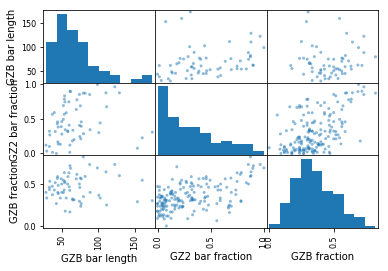

In [9]:
# bar_length_df.plot.scatter(x='GZ2 bar fraction', y='GZB bar length')
print('Spearman correlation:')
display(bar_length_df.corr('spearman'))
pd.plotting.scatter_matrix(bar_length_df);

In [10]:
bar_length_df[bar_length_df['GZB bar length'] > 150]

,GZB bar length,GZ2 bar fraction,GZB fraction
subject_id,,,
20902079,173.969952,0.308534,0.301587
20902080,153.494141,0.076164,0.288889
21096787,160.200000,0.226558,0.545455


In [57]:
sandor_bars = pd.read_csv('Kruk2018_Table2_Table3.csv')
sandor_bars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461 entries, 0 to 3460
Data columns (total 57 columns):
SDSS_dr8objid     3461 non-null int64
ra                3461 non-null float64
dec               3461 non-null float64
Fit_components    3461 non-null object
u_disc            3461 non-null float64
g_disc            3461 non-null float64
r_disc            3461 non-null float64
i_disc            3461 non-null float64
z_disc            3461 non-null float64
n_disc            3461 non-null float64
re_disc           3461 non-null float64
ba_disc           3461 non-null float64
u_bar             3461 non-null float64
g_bar             3461 non-null float64
r_bar             3461 non-null float64
i_bar             3461 non-null float64
z_bar             3461 non-null float64
n_bar             3461 non-null float64
re_bar            3461 non-null float64
ba_bar            3461 non-null float64
u_bulge           3461 non-null float64
g_bulge           3461 non-null float64
r_bulge         

In [12]:
skyserver_url = '/'.join((
    'http://skyserver.sdss.org',
    'dr13', 'en','tools', 'search',
    'x_results.aspx'
))

def get_dr8_id(dr7id_list):
    dr7id_list = json.dumps(dr7id_list).replace('[', '(').replace(']', ')')
    cmd = 'SELECT {} FROM {} WHERE dr7objid IN {}'.format(
        'dr7objid, dr8objid',
        'PhotoObjDR7',
        dr7id_list
    )
    payload = {
        'searchtool': 'SQL',
        'TaskName': 'Skyserver.Search.SQL',
        'syntax': 'NoSyntax',
        'cmd': cmd,
        'format': 'json',
        'TableName': '',
    }
    r = requests.get(
        skyserver_url,
        params=payload,
    )
    try:
        return r.json()[0]['Rows']
    except json.JSONDecodeError:
        print('Could not parse JSON')
        return []

In [13]:
dr7objids = pd.DataFrame(
    list(zip(
        map(
            np.int64,
            (gu.meta_map[subject_id]['SDSS dr7 id']
             for subject_id in bar_length_df.index.values)
        ),
        bar_length_df.index.values
    )),
    columns=('dr7objid', 'subject_id')
)
dr7objids.head(3)

,dr7objid,subject_id
0,587741600952615088,20902000
1,587742573223542941,20902007
2,587741600410632336,20902059


In [14]:
objid_table = pd.DataFrame(get_dr8_id(dr7objids['dr7objid'].values.tolist()))

In [15]:
out = []
for i in range(len(dr7objids)):
    subject_id = dr7objids['subject_id'].iloc[i]
    dr7id = dr7objids['dr7objid'].iloc[i]
    poss_dr8ids = objid_table['dr8objid'][objid_table['dr7objid'] == dr7id]
    for dr8id in poss_dr8ids:
        out.append((subject_id, dr8id))
dr8objids = pd.DataFrame(out, columns=('subject_id', 'dr8objid'))
dr8objids.head()

,subject_id,dr8objid
0,20902000,1237667322177519773
1,20902007,1237668294448447638
2,20902059,1237667321635537067
3,20902062,1237662640660021320
4,20902073,1237668603144569057


Now to link Sandor's table to a GZB subject id!

In [16]:
out = [[0, 0]]
for i, gal in sandor_bars.iterrows():
    m = dr8objids['dr8objid'] == gal['SDSS_dr8objid']
    if np.any(m):
        sids = dr8objids[m]['subject_id'].values
        new = np.stack(
            (sids, np.tile(gal['SDSS_dr8objid'], len(sids))),
            axis=1,
        )
        out = np.concatenate((
            out,
            new
        ))
out = out[1:]

And now link these subject ids to Sandor's classification!

In [72]:
gzb_sandor = pd.DataFrame({
    'subject_id': out[:, 0],
    'sandor_bar_length': sandor_bars.set_index(
        'SDSS_dr8objid'
    ).loc[out[:, 1]]['re_bar'].values,
    'gzb_bar_length': bar_length_df.loc[out[:, 0]]['GZB bar length']
}).set_index('subject_id')

,sandor_bar_length,gzb_bar_length
subject_id,,
20902064,13.68,110.358061
21686593,13.68,128.819024
21686549,11.09,75.166667


,sandor_bar_length,gzb_bar_length
sandor_bar_length,1.000000,0.867288
gzb_bar_length,0.867288,1.000000


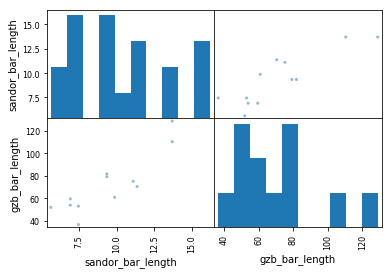

In [77]:
display(gzb_sandor.corr('pearson'))
pd.plotting.scatter_matrix(gzb_sandor);